In [ ]:
%load_ext autoreload
%autoreload 2

from data_prep import DataPreparation, filtering_data
from lstm import LSTMModelTrainerAttention
from rf import RandomForestTrainer
from lgbm import LightGBMTrainer
from catboost_trainer import CatBoostTrainer
import os
import dill as pickle
import numpy as np
import pandas as pd
from analysis import plot_correlation_heatmap, get_ETO_DEP
from lstm import LSTMModelTrainerAttention, calculate_and_plot_errors#, LSTMModelTrainer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.ticker as ticker
from tqdm import tqdm
from lstm import LSTMRollingForecaster
from collections import defaultdict
import matplotlib.pyplot as plt
from helper import extract_flight_details
from lstm import LSTMModelTrainerAttention, LSTMRollingForecaster
from rf import RandomForestTrainer
from lgbm import LightGBMTrainer
from catboost_trainer import CatBoostTrainer
from transformer import TransformerTrainer
import warnings
warnings.simplefilter(action='ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
output= r'C:\Users\iLabs_6\Documents\Tex\realtimetest'
modelname = 'extended_ATOT_RT'

 
with  open(os.path.join(output, modelname), 'rb') as f:  
    extended_df = pickle.load(f)

extended_df['cap_DEP'].fillna(extended_df['cap_DEP'].mean(), inplace=True)
extended_df['cap_DES'].fillna(extended_df['cap_DES'].mean(), inplace=True)
extended_df = extended_df.loc[:, ~extended_df.columns.str.contains('t_to_eobt', case=False)]
extended_df = extended_df.loc[:, ~extended_df.columns.str.contains('t_to_atot', case=False)]
pd.set_option("display.max_columns", None)
X, y, colnames = filtering_data(extended_df, airport ='EHAM', save=True)
X = X.drop(['ADES_EHAM', 'ADESLong', 'ADESLat', 'cbasentry'], axis =1)
X.describe()

output= r'C:\Users\iLabs_6\Documents\Tex\realtimetest'
modelname = 'extended_ETOT_RT'


with  open(os.path.join(output, modelname), 'rb') as f:  
    extended_real= pickle.load(f)
extended_real = extended_real.loc[:, ~extended_real.columns.str.contains('t_to_eobt', case=False)]
extended_real = extended_real.loc[:, ~extended_real.columns.str.contains('t_to_atot', case=False)]

pd.set_option("display.max_columns", None)
print(f'{extended_real}')
X_r, y_r, colnames = filtering_data(extended_real, airport ='EHAM', save=False)
X_r = X_r.drop(['ADES_EHAM', 'ADESLong', 'ADESLat', 'cbasentry'], axis =1)
# X.fillna(0, inplace=True)
print(f'xxxxx = {X_r}')


modelpath= r"C:\Users\iLabs_6\Documents\Tex\AirTrafficDelays\LSTM_Models"

modelname = 'lstm-9-100-2shift-2887'
# with open(os.path.join(output, modelname), 'wb') as f:  
#     pickle.dump(best_model, f, protocol=pickle.HIGHEST_PROTOCOL)
#     print(f"FlightDataset has been saved successfully. {modelname}")
###
with  open(os.path.join(modelpath, modelname), 'rb') as f:  
    best_model = pickle.load(f)

           distance                ETOT  ADEP  ADES                EOBT  \
0       1992.934496 2024-03-01 08:43:00  LFLL  EHAM 2024-03-01 08:35:00   
1       1992.934496 2024-03-01 08:43:00  LFLL  EHAM 2024-03-01 08:35:00   
2       1992.934496 2024-03-01 08:43:00  LFLL  EHAM 2024-03-01 08:35:00   
3       1992.934496 2024-03-01 08:43:00  LFLL  EHAM 2024-03-01 08:35:00   
4       1992.934496 2024-03-01 14:03:00  LFLL  EHAM 2024-03-01 13:55:00   
...             ...                 ...   ...   ...                 ...   
26679  15512.634974 2024-03-25 17:35:00  LFPG  EHAM 2024-03-25 17:15:00   
26680  14437.477905 2024-03-25 20:00:00  LSZH  EHAM 2024-03-25 19:45:00   
26681  14437.477905 2024-03-25 20:00:00  LSZH  EHAM 2024-03-25 19:45:00   
26682  14437.477905 2024-03-25 20:00:00  LSZH  EHAM 2024-03-25 19:45:00   
26683  14437.477905 2024-03-25 20:00:00  LSZH  EHAM 2024-03-25 19:45:00   

                      ETA    CDMStatus  taxitime event  regulations  \
0     2024-03-01 09:48:00  D

In [99]:
data_prep = DataPreparation()


X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, time_horizons, cbaslabels = data_prep.fit_transform_data(X, y)
X_real, ETOT_horizons, cbaslabels = data_prep.transform_data(X_r)

X_train, X_test, y_train, y_test = data_prep.fit_transform_data(X, y, split_ratio=0.8, mode='rf')
max(y_r)

skip=['CBAS', 'cbas', 'eobt', 'atot']
time_varying_columns=['atfmdelay_Tmin_-300', 'regulations_Tmin_-300', 'cobt_delay_Tmin_-300', 'eflighttime_Tmin_-300', 'visibility_Tmin_-300', 'ko_Tmin_-300', 'TSATdelay_Tmin_-300', 'TOBTdelay_Tmin_-300', 'etodepdelay_Tmin_-300', 'timetoCBAS_Tmin_-300', 'offblock_Tmin_-300', 'wspeed_Tmin_-300', 'wdirec_Tmin_-300', 'wguts_Tmin_-300', 'fltstate_SI_Tmin_-300', 'fltstate_FI_Tmin_-300', 'fltstate_other_Tmin_-300', 'modeltyp_ACT_Tmin_-300', 'modeltyp_CAL_Tmin_-300', 'modeltyp_EST_Tmin_-300', 'atfmdelay_Tmin_-295', 'regulations_Tmin_-295', 'cobt_delay_Tmin_-295', 'eflighttime_Tmin_-295', 'visibility_Tmin_-295', 'ko_Tmin_-295', 'TSATdelay_Tmin_-295', 'TOBTdelay_Tmin_-295', 'etodepdelay_Tmin_-295', 'timetoCBAS_Tmin_-295', 'offblock_Tmin_-295', 'wspeed_Tmin_-295', 'wdirec_Tmin_-295', 'wguts_Tmin_-295', 'fltstate_SI_Tmin_-295', 'fltstate_FI_Tmin_-295', 'fltstate_other_Tmin_-295', 'modeltyp_ACT_Tmin_-295', 'modeltyp_CAL_Tmin_-295', 'modeltyp_EST_Tmin_-295', 'a

118.0

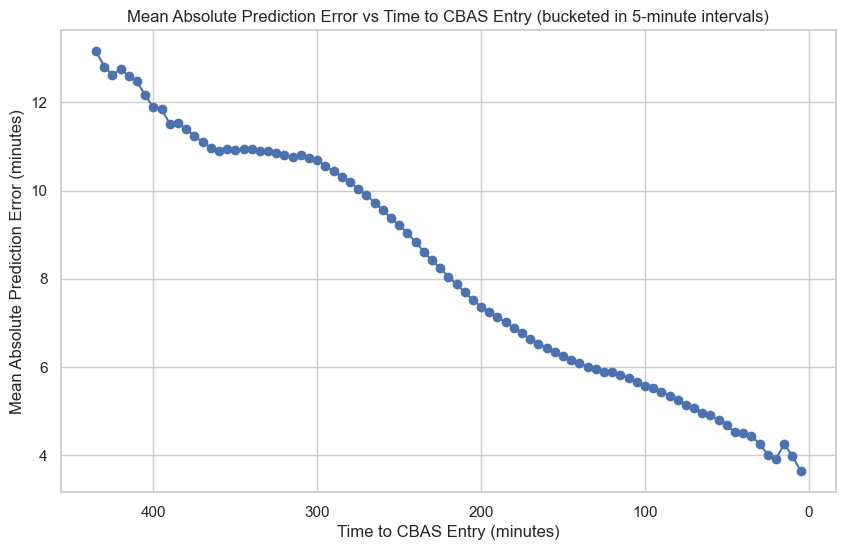

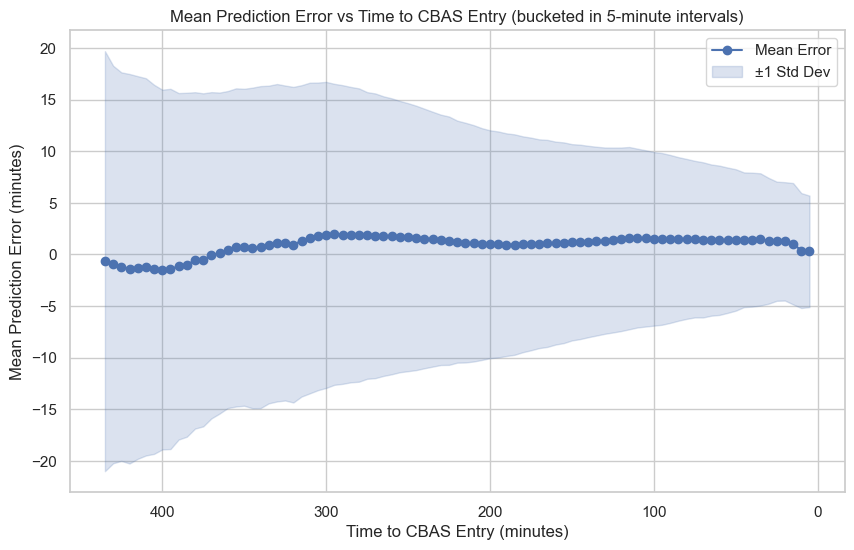

In [101]:


# Initialize variables
# ap = []
# target_length = 61  # Target length for each error array
# start_idx, end_idx = -1000, -100  # Define your index range as variables
# # start_idx, end_idx = 16000, 16500  # Define your index range as variables

# abs_error_dict = {}
# error_dict = {}
# e_adep = defaultdict(list)
# e_dist =  defaultdict(list)
# e_wd =  defaultdict(list)
# e_time =  defaultdict(list)
# adeplonglist = defaultdict(list)
# adeplatlist = defaultdict(list)
# adeplatlonlist = defaultdict(list)
# # Loop through the specified range in `y_r`
# for fnr in tqdm(np.where((y_r <= 130))[0]):#[start_idx:end_idx]):
#     # Create rolling forecaster instance
#     recursive = LSTMRollingForecaster(best_model, data_prep, X_real[fnr], ETOT_horizons)
#     pred = recursive.rolling_forecast()
#     # Calculate absolute error per timestep
#     absolute_error_per_timestep = np.abs(pred[-target_length:] - y_r[fnr])[::-1]
#     error_per_timestep = (pred[-target_length:] - y_r[fnr])[::-1]
#     clabel = [x.astype('timedelta64[s]').astype(int) / 60 for x in cbaslabels[fnr] if not np.isnat(x)][-target_length:][::-1]

#     if len(absolute_error_per_timestep) > len(clabel):
#         absolute_error_per_timestep = absolute_error_per_timestep[-len(clabel):]
#         error_per_timestep = error_per_timestep[-len(clabel):]

#     # Loop over the filtered `clabel` and `absolute_error_per_timestep`
#     for i in range(len(absolute_error_per_timestep)):
#         time_to_cbas = np.round(clabel[i], 0)
#         if time_to_cbas not in abs_error_dict:
#             error_dict[time_to_cbas] = []
#             abs_error_dict[time_to_cbas] = []
#         abs_error_dict[time_to_cbas].append(absolute_error_per_timestep[i])
#         error_dict[time_to_cbas].append(error_per_timestep[i])


#     ### FOR ATOT GRAPTH ANA:LYYSY

#     absolute_error_per_timestep = np.abs(pred[-target_length:] - y_r[fnr])

#     # Ensure each error array has `target_length` elements by padding with NaNs if needed
#     if len(absolute_error_per_timestep) < target_length:
#         absolute_error_per_timestep = np.pad(absolute_error_per_timestep, (0, target_length - len(absolute_error_per_timestep)), constant_values=np.nan)
    
#     inv  = data_prep.inverse_transform_single_flight(X_real[fnr])
#     info = extract_flight_details(inv)

#     e_adep[info['adep']].append(absolute_error_per_timestep)
#     e_dist[info['distance']].append(absolute_error_per_timestep)
#     e_wd[info['day']].append(absolute_error_per_timestep)
#     e_time[info['time']].append(absolute_error_per_timestep)
#     adeplonglist[info['longitude']].append(absolute_error_per_timestep)
#     adeplatlist[info['latitude']].append(absolute_error_per_timestep)
#     adeplatlonlist[(info['latitude'], info['longitude'])].append(absolute_error_per_timestep)

# Bucket the errors into 5-minute intervals
bucketed_abs_errors = defaultdict(list)
for time_in_minutes, errors in abs_error_dict.items():
    bucket = int(time_in_minutes // 5) * 5   # Group into 5-minute buckets
    bucketed_abs_errors[bucket].extend(errors)   # Aggregate errors within the bucket

bucketed_errors = defaultdict(list)
for time_in_minutes, errors in error_dict.items():
    bucket = int(time_in_minutes // 5) * 5   # Group into 5-minute buckets
    bucketed_errors[bucket].extend(errors)   # Aggregate errors within the bucket

# Compute the mean and standard deviation of error for each bucket
mean_abs_errors_by_bucket = {bucket: np.nanmean(errors) for bucket, errors in bucketed_abs_errors.items()}
mean_errors_by_bucket = {bucket: np.nanmean(errors) for bucket, errors in bucketed_errors.items()}
std_errors_by_bucket = {bucket: np.nanstd(errors) for bucket, errors in bucketed_errors.items()}

# Sort the buckets
sorted_abs_buckets = sorted(mean_abs_errors_by_bucket.items())
sorted_buckets = sorted(mean_errors_by_bucket.items())
sorted_std_buckets = sorted(std_errors_by_bucket.items())

# Extract sorted times and mean errors for plotting
abs_times = [item[0] for item in sorted_abs_buckets]
abs_errors = [item[1] for item in sorted_abs_buckets]
times = [item[0] for item in sorted_buckets]
errors = [item[1] for item in sorted_buckets]
std_errors = [item[1] for item in sorted_std_buckets]

# Plot Mean Absolute Prediction Error
plt.figure(figsize=(10, 6))
plt.plot(abs_times[:-10], abs_errors[:-10], marker='o', linestyle='-')
plt.title("Mean Absolute Prediction Error vs Time to CBAS Entry (bucketed in 5-minute intervals)")
plt.xlabel("Time to CBAS Entry (minutes)")
plt.ylabel("Mean Absolute Prediction Error (minutes)")
ax = plt.gca()
ax.invert_xaxis()

plt.grid(True)
plt.show()

# Plot Mean Prediction Error with Standard Deviation as Fill
plt.figure(figsize=(10, 6))
plt.plot(times[:-10], errors[:-10], marker='o', linestyle='-', label='Mean Error')
plt.fill_between(
    times[:-10],
    [e - s for e, s in zip(errors[:-10], std_errors[:-10])],
    [e + s for e, s in zip(errors[:-10], std_errors[:-10])],
    color='b',
    alpha=0.2,
    label='±1 Std Dev'
)
plt.title("Mean Prediction Error vs Time to CBAS Entry (bucketed in 5-minute intervals)")
plt.xlabel("Time to CBAS Entry (minutes)")
plt.ylabel("Mean Prediction Error (minutes)")
plt.legend()
ax = plt.gca()
ax.invert_xaxis()

plt.grid(True)
plt.show()

# Calculate mean absolute error (MAE) per timestep, ignoring NaNs in the calculation

In [ ]:
data_to_save = {
    'abs_error_dict': abs_error_dict,
    'error_dict': error_dict,
    'e_adep': e_adep,
    'e_dist': e_dist,
    'e_wd': e_wd,
    'e_time': e_time,
    'adeplonglist': adeplonglist,
    'adeplatlist': adeplatlist,
    'adeplatlonlist': adeplatlonlist,
    'bucketed_abs_errors': bucketed_abs_errors,
    'bucketed_errors': bucketed_errors,
    'mean_abs_errors_by_bucket': mean_abs_errors_by_bucket,
    'mean_errors_by_bucket': mean_errors_by_bucket,
    'std_errors_by_bucket': std_errors_by_bucket,
    'sorted_abs_buckets': sorted_abs_buckets,
    'sorted_buckets': sorted_buckets,
    'sorted_std_buckets': sorted_std_buckets,
    'abs_times': abs_times,
    'abs_errors': abs_errors,
    'times': times,
    'errors': errors,
    'std_errors': std_errors
}

# Save to a pickle file
output_file = r"C:\Users\iLabs_6\Documents\Tex\AirTrafficDelays\output\error_analysis_data.pkl"
with open(output_file, 'wb') as file:
    pickle.dump(data_to_save, file, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Data saved to {output_file}")

with open(output_file, 'rb') as file:
    loaded_data = pickle.load(file)

# Access the variables
abs_error_dict = loaded_data['abs_error_dict']
error_dict = loaded_data['error_dict']
e_adep = loaded_data['e_adep']
e_dist = loaded_data['e_dist']
e_wd = loaded_data['e_wd']
e_time = loaded_data['e_time']
adeplonglist = loaded_data['adeplonglist']
adeplatlist = loaded_data['adeplatlist']
adeplatlonlist = loaded_data['adeplatlonlist']
bucketed_abs_errors = loaded_data['bucketed_abs_errors']
bucketed_errors = loaded_data['bucketed_errors']
mean_abs_errors_by_bucket = loaded_data['mean_abs_errors_by_bucket']
mean_errors_by_bucket = loaded_data['mean_errors_by_bucket']
std_errors_by_bucket = loaded_data['std_errors_by_bucket']
sorted_abs_buckets = loaded_data['sorted_abs_buckets']
sorted_buckets = loaded_data['sorted_buckets']
sorted_std_buckets = loaded_data['sorted_std_buckets']
abs_times = loaded_data['abs_times']
abs_errors = loaded_data['abs_errors']
times = loaded_data['times']
errors = loaded_data['errors']
std_errors = loaded_data['std_errors']

print("Data successfully loaded from", output_file)

Data saved to C:\Users\iLabs_6\Documents\Tex\AirTrafficDelays\output\error_analysis_data.pkl


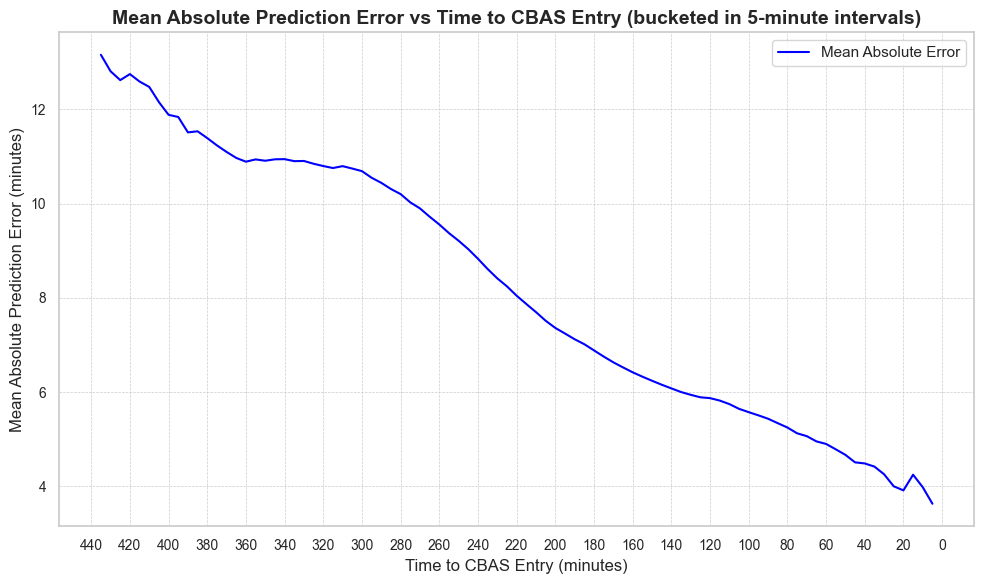

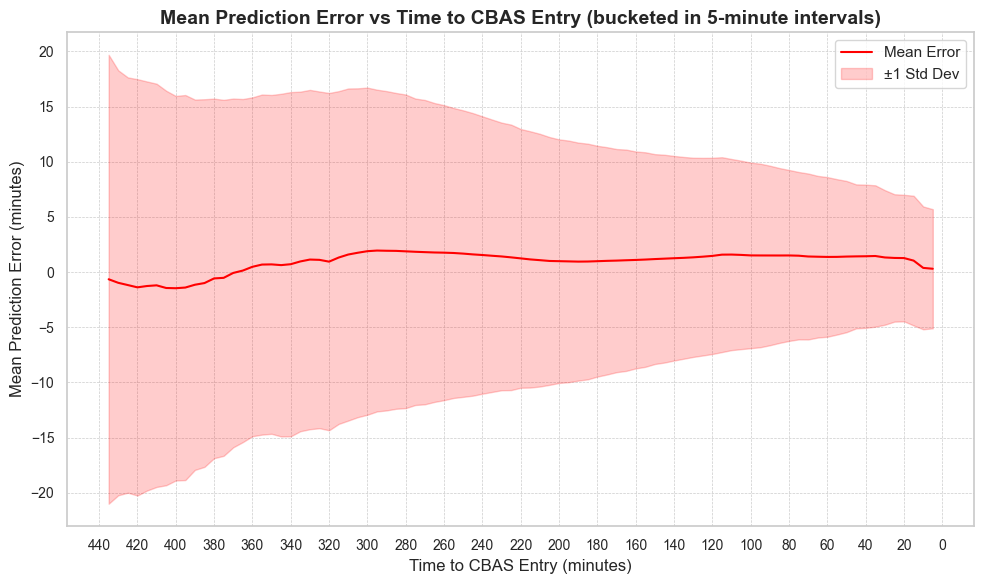

In [102]:
# Set Seaborn style
sns.set(style="whitegrid")

# Define the tick interval
tick_interval = 20

# Create the first plot
plt.figure(figsize=(10, 6))

# Plot using Seaborn's lineplot
sns.lineplot(x=abs_times[:-10], y=abs_errors[:-10], marker='', linestyle='-', color='blue', label='Mean Absolute Error')

# Set titles and labels
plt.title("Mean Absolute Prediction Error vs Time to CBAS Entry (bucketed in 5-minute intervals)", fontsize=14, weight='bold')
plt.xlabel("Time to CBAS Entry (minutes)", fontsize=12)
plt.ylabel("Mean Absolute Prediction Error (minutes)", fontsize=12)

# Invert the x-axis
ax = plt.gca()  # Get current Axes instance
ax.invert_xaxis()

# Set x-axis ticks at intervals of 20
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_interval))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))  # Optional: Minor ticks every 5 minutes

# Add grid lines for major ticks
ax.grid(which='major', linestyle='--', linewidth=0.5)

# Optional: Customize tick parameters for better readability
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Optional: Add a legend if multiple lines are present
plt.legend()

# Display the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

# Define the tick interval
tick_interval = 20

# Create the second plot
plt.figure(figsize=(10, 6))

# Plot the mean error using Seaborn's lineplot
sns.lineplot(x=times[:-10], y=errors[:-10], marker='', linestyle='-', color='red', label='Mean Error')

# Add the standard deviation as a shaded area
plt.fill_between(
    times[:-10],
    np.array(errors[:-10]) - np.array(std_errors[:-10]),
    np.array(errors[:-10]) + np.array(std_errors[:-10]),
    color='red',
    alpha=0.2,
    label='±1 Std Dev'
)

# Set titles and labels
plt.title("Mean Prediction Error vs Time to CBAS Entry (bucketed in 5-minute intervals)", fontsize=14, weight='bold')
plt.xlabel("Time to CBAS Entry (minutes)", fontsize=12)
plt.ylabel("Mean Prediction Error (minutes)", fontsize=12)

# Invert the x-axis
ax = plt.gca()
ax.invert_xaxis()

# Set x-axis ticks at intervals of 20
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_interval))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))  # Optional: Minor ticks every 5 minutes

# Add grid lines for major ticks
ax.grid(which='major', linestyle='--', linewidth=0.5)

# Customize tick parameters
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add a legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

sorted_buckets=[(40, 2.5289018009917403), (45, 3.285524913023519), (50, 3.8752766743684006), (55, 5.151778038296209), (60, 6.094995769737116), (65, 6.800018780090827), (70, 7.377376440281208), (75, 7.8790649411746845), (80, 8.315890612610358), (85, 8.719859471805204), (90, 9.134460897574524), (95, 9.506610781669114), (100, 9.842886708627837), (105, 10.131965232171243), (110, 10.426809622994417), (115, 10.688013939000747), (120, 10.949870056947306), (125, 11.207795444974332), (130, 11.451470538021148), (135, 11.65971651547745), (140, 11.863951331110073), (145, 12.070775712600112), (150, 12.316149360528422), (155, 12.546174931803609), (160, 12.816800213979217), (165, 13.056167268008966), (170, 13.299105384764225), (175, 13.560374008354296), (180, 13.818256145263055), (185, 14.017024436881822), (190, 14.194147440785805), (195, 14.428882641505139), (200, 14.586791715513872), (205, 14.756140330908995), (210, 14.916712952951128), (215, 15.115898579921618), (220, 15.25731873418394), (225, 15.

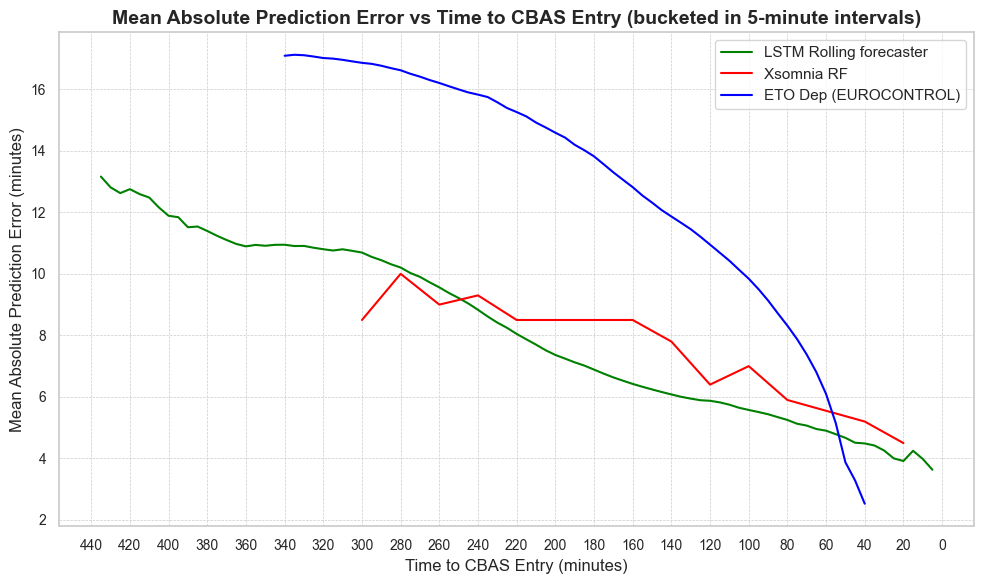

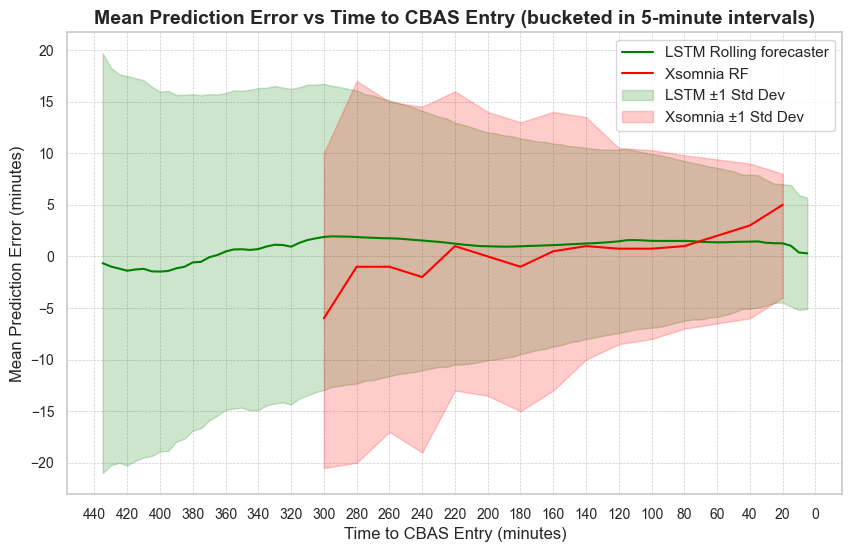

In [103]:
# Set Seaborn style
sns.set(style="whitegrid")
etodeplist, etodict = get_ETO_DEP(extended_df, plot=False)
print(f'{etodict=}')
Xsomnia_line = {
    300: -6, 280: -1, 260: -1, 240: -2, 220: 1, 200: 0, 180: -1,
    160: 0.5, 140: 1, 120: 0.75, 100: 0.75, 80: 1, 60: 2, 40: 3, 20: 5
}
Xsomnia_ub = {
    300: 10, 280: 17, 260: 15, 240: 14.5, 220: 16, 200: 14, 180: 13,
    160: 14, 140: 13.5, 120: 10.5, 100: 10.3, 80: 9.8, 40: 9, 20: 8
}
Xsomnia_lb = {
    300: -20.5, 280: -20, 260: -17, 240: -19, 220: -13, 200: -13.5, 180: -15,
    160: -13, 140: -10, 120: -8.5, 100: -8, 80: -7, 40: -6, 20: -4
}
Xsomnia_mae = {
    300: 8.5,
    280: 10,
    260: 9,
    240: 9.3,
    220: 8.5,
    200: 8.5,
    180: 8.5,
    160: 8.5,
    140: 7.8,
    120: 6.4,
    100: 7,
    80: 5.9,
    40: 5.2,
    20: 4.5
}

# Define the tick interval
tick_interval = 20

# Create the first plot
plt.figure(figsize=(10, 6))

# Plot using Seaborn's lineplot
sns.lineplot(x=abs_times[:-10], y=abs_errors[:-10], marker='', linestyle='-', color='green', label='LSTM Rolling forecaster')
sns.lineplot(x=Xsomnia_mae.keys(), y=Xsomnia_mae.values(), marker='', linestyle='-', color='red', label='Xsomnia RF')
sns.lineplot(x=etodict.keys(), y=etodict.values(), marker='', linestyle='-', color='blue', label='ETO Dep (EUROCONTROL)')

# Set titles and labels
plt.title("Mean Absolute Prediction Error vs Time to CBAS Entry (bucketed in 5-minute intervals)", fontsize=14, weight='bold')
plt.xlabel("Time to CBAS Entry (minutes)", fontsize=12)
plt.ylabel("Mean Absolute Prediction Error (minutes)", fontsize=12)

# Invert the x-axis
ax = plt.gca()  # Get current Axes instance
ax.invert_xaxis()

# Set x-axis ticks at intervals of 20
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_interval))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))  # Optional: Minor ticks every 5 minutes

# Add grid lines for major ticks
ax.grid(which='major', linestyle='--', linewidth=0.5)

# Optional: Customize tick parameters for better readability
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Optional: Add a legend if multiple lines are present
plt.legend()

# Display the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

# Define the tick interval
tick_interval = 20

# Create the second plot
plt.figure(figsize=(10, 6))

# Plot the mean error using Seaborn's lineplot
sns.lineplot(x=times[:-10], y=errors[:-10], marker='', linestyle='-', color='green', label='LSTM Rolling forecaster')
sns.lineplot(x=Xsomnia_line.keys(), y=Xsomnia_line.values(), marker='', linestyle='-', color='red', label='Xsomnia RF')

# Add the standard deviation as a shaded area
plt.fill_between(
    times[:-10],
    np.array(errors[:-10]) - np.array(std_errors[:-10]),
    np.array(errors[:-10]) + np.array(std_errors[:-10]),
    color='green',
    alpha=0.2,
    label='LSTM ±1 Std Dev'
)

plt.fill_between(
    Xsomnia_mae.keys(),
    Xsomnia_ub.values(),
    Xsomnia_lb.values(),
    color="red",
    alpha=0.2,
    label="Xsomnia ±1 Std Dev"
)
# Set titles and labels
plt.title("Mean Prediction Error vs Time to CBAS Entry (bucketed in 5-minute intervals)", fontsize=14, weight='bold')
plt.xlabel("Time to CBAS Entry (minutes)", fontsize=12)
plt.ylabel("Mean Prediction Error (minutes)", fontsize=12)

# Invert the x-axis
ax = plt.gca()
ax.invert_xaxis()

# Set x-axis ticks at intervals of 20
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_interval))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))  # Optional: Minor ticks every 5 minutes

# Add grid lines for major ticks
ax.grid(which='major', linestyle='--', linewidth=0.5)

# Customize tick parameters
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add a legend
plt.legend()

# Display the plot
plt.tight_layout
()
plt.show()

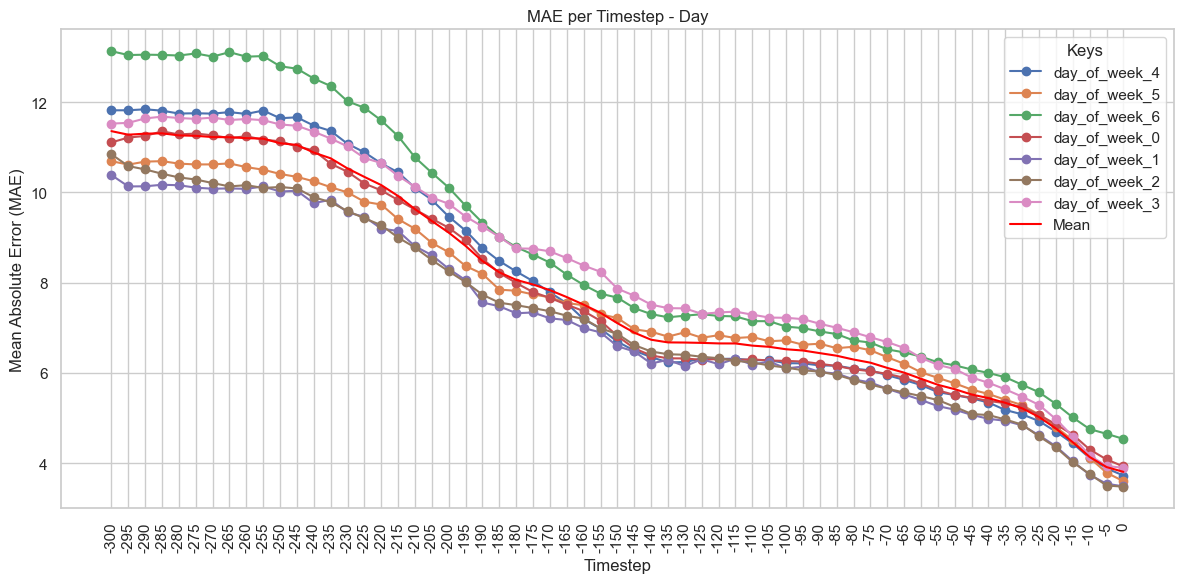

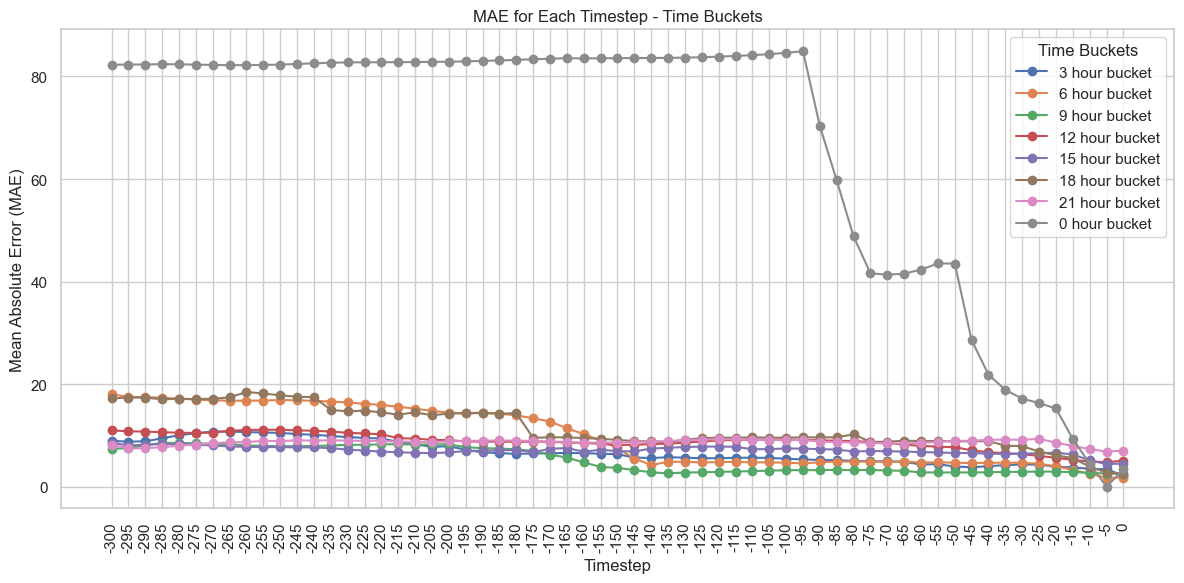

In [135]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
from collections import defaultdict

warnings.filterwarnings("ignore", category=UserWarning)

# Function to plot a dictionary of errors
def plot_dict_errors(error_dict, title):
    plt.figure(figsize=(12, 6))
    maelist = []
    for key, errors in error_dict.items():
        # print(f'{key=}')
        # print(f'{len(errors)=}')
        mae_per_timestep = np.nanmean(errors, axis=0)
        maelist.append(mae_per_timestep)
        plt.plot(ETOT_horizons[:target_length], mae_per_timestep, marker='o', label=key)
    plt.plot(ETOT_horizons[:target_length], np.nanmean(maelist,axis=0), marker='', label='Mean', color='red')

    plt.xlabel('Timestep')
    plt.xticks(ETOT_horizons[:target_length], rotation='vertical')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title(title)
    plt.legend(title="Keys")
    plt.tight_layout()
    plt.grid(True)
    plt.show()

# plot_dict_errors(e_adep, "MAE per Timestep - ADEP")
# plot_dict_errors(e_dist, "MAE per Timestep - Distance")
plot_dict_errors(e_wd, "MAE per Timestep - Day")
# plot_dict_errors(adeplonglist, "MAE per Timestep - Long")
# plot_dict_errors(adeplatlist, "MAE per Timestep - Lat")

bucketed_errors = defaultdict(list)

for time_key, errors in e_time.items():
    time_to_cbas = time_key  # Use time_key as time to CBAS (assuming time_key is in minutes)
    bucket = int(time_to_cbas//180 )  *3 # Group into 60 minute intervals
    bucketed_errors[bucket].append(errors)

bucketed_dist = defaultdict(list)
for time_key, errors in e_dist.items():
  # Use time_key as time to CBAS (assuming time_key is in minutes)
    bucket = int(time_key//5000 )*5000   # Group into 60 minute intervals
    bucketed_dist[bucket].append(errors)
# print(f'{bucketed_dist.keys()}')

# Plot the bucketed errors for e_time
plt.figure(figsize=(12, 6))
for bucket, edict in bucketed_errors.items():
    # print(f'{bucket=}')
    # print(f'{edict=}')
    mae_per_timestep = np.nanmean(edict[0], axis=0)

    plt.plot(ETOT_horizons[:target_length], mae_per_timestep, marker='o', label=f"{bucket} hour bucket")
plt.xlabel('Timestep')
plt.xticks(ETOT_horizons[:target_length], rotation='vertical')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('MAE for Each Timestep - Time Buckets')
plt.legend(title="Time Buckets")
plt.tight_layout()
plt.grid(True)
plt.show()

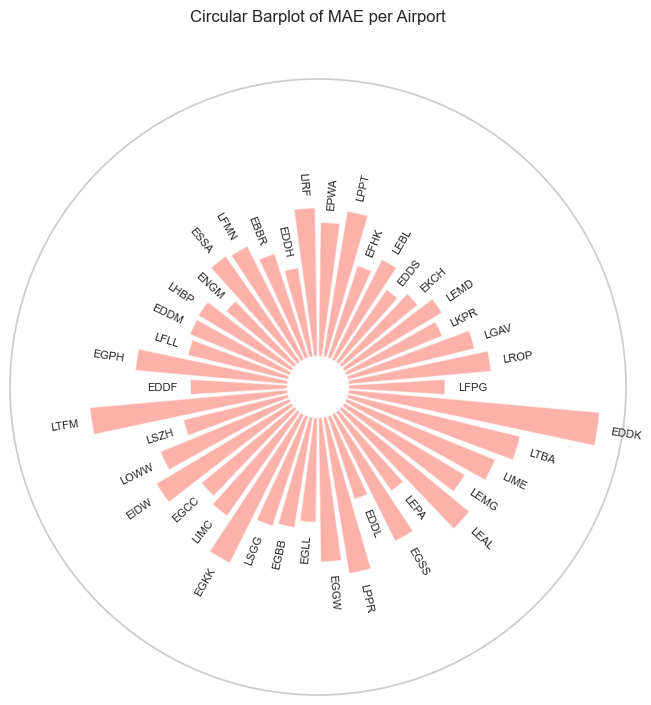

In [ ]:
# Create a DataFrame for the plot
data = pd.DataFrame({'Airport': [x.split('ADEP_')[1] for x in e_adep.keys()], 'MAE': [np.nanmean(x) for x in e_adep.values()]})


# Number of airports
N = len(data)

# Compute angle for each bar
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]  # Complete the loop

# Heights of bars
heights = data['MAE'].tolist()
heights += heights[:1]  # Complete the loop

# Initialize the plot
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Remove labels and ticks
ax.set_xticks([])
ax.set_yticks([])

# Set the minimum radius (distance from center where bars start)
bottom = 2.0  # Adjust this value to change how far bars start from the center

# Add bars
bar_width = 2 * np.pi / N * 0.8  # Adjust the 0.8 factor to change bar width (spacing between bars)
bars = ax.bar(angles[:-1], heights[:-1], width=bar_width, bottom=bottom, color='salmon', alpha=0.6)

# Adjust the maximum radius to ensure all bars and labels fit
max_height = bottom + max(heights) + max(heights) * 0.1  # Add some padding
ax.set_ylim(0, max_height)

# Add labels
for i, bar in enumerate(bars):
    angle = angles[i]
    rotation = np.degrees(angle)
    alignment = ''
    if rotation >= 270 or rotation <= 90:
        alignment = 'left'
        rotation = rotation
    else:
        alignment = 'right'
        rotation = rotation + 180
    # Position the label at the top of the bar
    ax.text(
        angle,
        bottom + heights[i] + max(heights) * 0.05,  # Adjust position based on 'bottom' and 'heights'
        data['Airport'].iloc[i],
        ha=alignment,
        va='center',
        rotation=rotation,
        rotation_mode='anchor',
        fontsize=8
    )

plt.title('Circular Barplot of MAE per Airport', y=1.08)
plt.show()

airport_errors=[[9.814841, 8.749309, 8.749309, 10.980009, 12.602117, 12.777525, 13.307285, 13.074545, 12.693459, 12.351301, 12.135954, 11.731073, 11.368133, 9.870015, 9.172261, 8.363258, 7.6028624, 6.614314, 5.521099, 4.804691, 4.892632, 3.60214, 0.01654017, 0.9732586, 0.8380133, 0.8167149, 0.8673092, 0.4970261, 0.2938925, 0.30458128, 0.39463294, 0.45588648, 0.59921896, 0.23413622, 0.038681626, 0.28985465, 0.46191657, 0.7282778, 0.59305155, 0.61540186, 0.6710354, 0.49876177, 0.5239254, 0.71506846, 0.8815228, 1.0355498, 0.9483019, 0.7836338, 0.8984486, 0.21781981, 0.108433366, 0.37104452, 0.8915504, 1.5193512, 2.400326, 2.6436522, 0.9961542, 1.7651392, 1.6570545, 1.2620465, 0.41665328], [7.0812473, 5.2637067, 4.4703603, 6.2961564, 7.921176, 10.748739, 11.359959, 11.698356, 11.975107, 12.326237, 12.364901, 12.587862, 14.082659, 14.044341, 14.209943, 13.972194, 14.059132, 14.020199, 13.847811, 13.64461, 13.466788, 13.014158, 13.1790905, 13.212701, 13.352436, 13.4886055, 13.493048, 13.2842

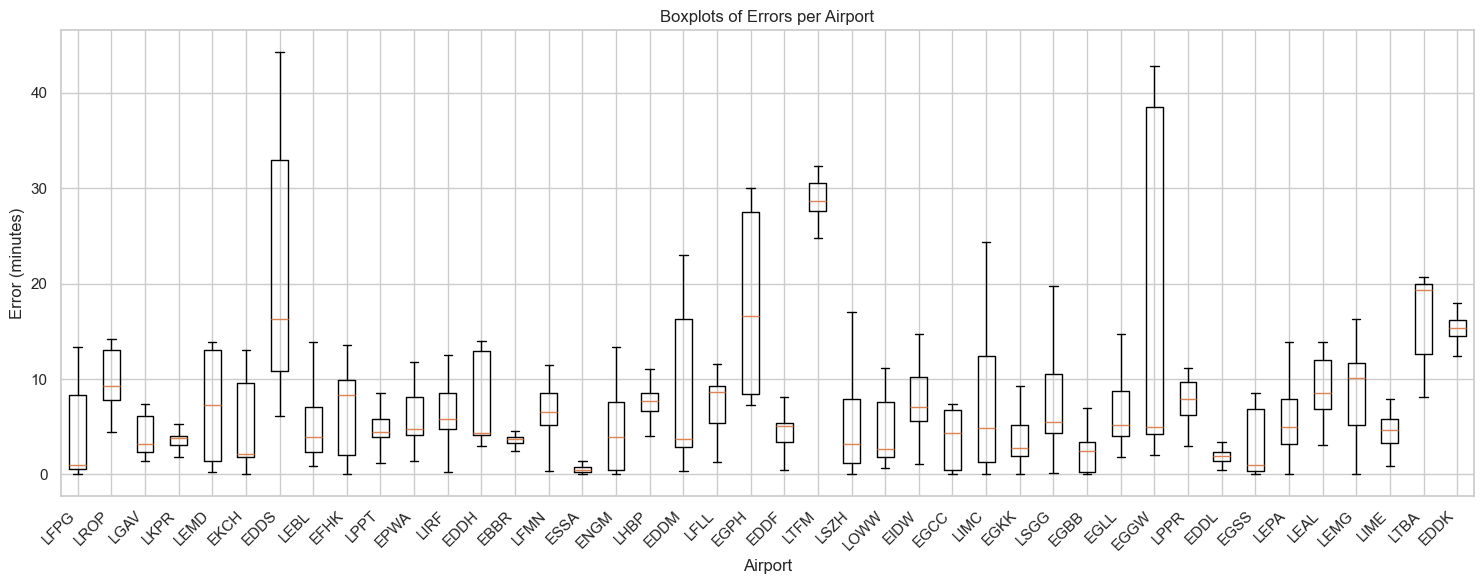

[27.392298,
 29.585028,
 29.589201,
 29.589201,
 29.589201,
 29.589201,
 29.589201,
 31.064106,
 30.481422,
 31.899319,
 31.95897,
 32.27266,
 32.275322,
 32.32889,
 32.252525,
 32.11361,
 32.073288,
 31.85553,
 31.498886,
 31.141226,
 30.821201,
 30.525988,
 30.324488,
 30.427444,
 30.496464,
 30.56278,
 30.432323,
 30.091661,
 29.628717,
 29.099115,
 28.547674,
 28.006416,
 27.589897,
 27.358013,
 28.369963,
 28.751307,
 28.574533,
 28.584677,
 28.470102,
 28.507252,
 28.604248,
 28.39207,
 28.369133,
 28.204622,
 27.984482,
 27.780928,
 27.680542,
 27.432728,
 27.106384,
 26.782385,
 26.528454,
 26.28047,
 25.86981,
 25.677402,
 24.71927,
 22.375391,
 21.783176,
 21.213398,
 20.577747,
 20.022758]

In [131]:

airport_errors = [[e for e in e_adep[airport][0] if not np.isnan(e)] for airport in e_adep.keys()]
airport_names = [x.split('ADEP_')[1] for x in e_adep.keys()]
print(f'{airport_errors=}')
# Create boxplots
plt.figure(figsize=(15, 6))
plt.boxplot(airport_errors, labels=airport_names, showfliers=False)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Airport')
plt.ylabel('Error (minutes)')
plt.title('Boxplots of Errors per Airport')
plt.tight_layout()
plt.show()
airport_errors[22]

In [127]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.cm as cm
tempmae = {}
print(f'{bucketed_errors.keys()}')
for k,v in bucketed_errors.items():
    tempmae[k] = np.mean(np.mean(v))

hourdata = pd.DataFrame({'Airport': [x for x in e_time.keys()], 'MAE': [np.nanmean(x) for x in e_time.values()]})

# Max number of airports to display
max_airports = 50
data_grid = hourdata.iloc[:max_airports].reset_index(drop=True)
num_airports = len(data_grid)

# Compute circle sizes (adjust scaling factor as needed)
max_mae = data_grid['MAE'].max()
sizes = data_grid['MAE'] / max_mae * 3000  # Adjust the multiplier to change circle sizes

# Normalize MAE values for color mapping
norm = mcolors.Normalize(vmin=data_grid['MAE'].min(), vmax=data_grid['MAE'].max())
cmap = cm.get_cmap('coolwarm')
colors = [cmap(norm(value)) for value in data_grid['MAE']]

# Grid dimensions
grid_rows = 5
grid_cols = 10

fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols*1.5, grid_rows*1.5))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < num_airports:
        mae_value = data_grid['MAE'].iloc[i]
        color = colors[i]
        ax.scatter(0.5, 0.5, s=sizes.iloc[i], color=color, alpha=0.6)
        ax.text(0.5, 0.5, f"{mae_value:.1f}", ha='center', va='center', fontsize=12)
        ax.axis('off')  # Remove the box around the circle
        ax.set_title(data_grid['Airport'].iloc[i], fontsize=10)
    else:
        ax.axis('off')  # Hide unused subplots

plt.suptitle('MAE per Airport', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

dict_keys([3, 6, 9, 12, 15, 18, 21, 0])


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (27,) + inhomogeneous part.

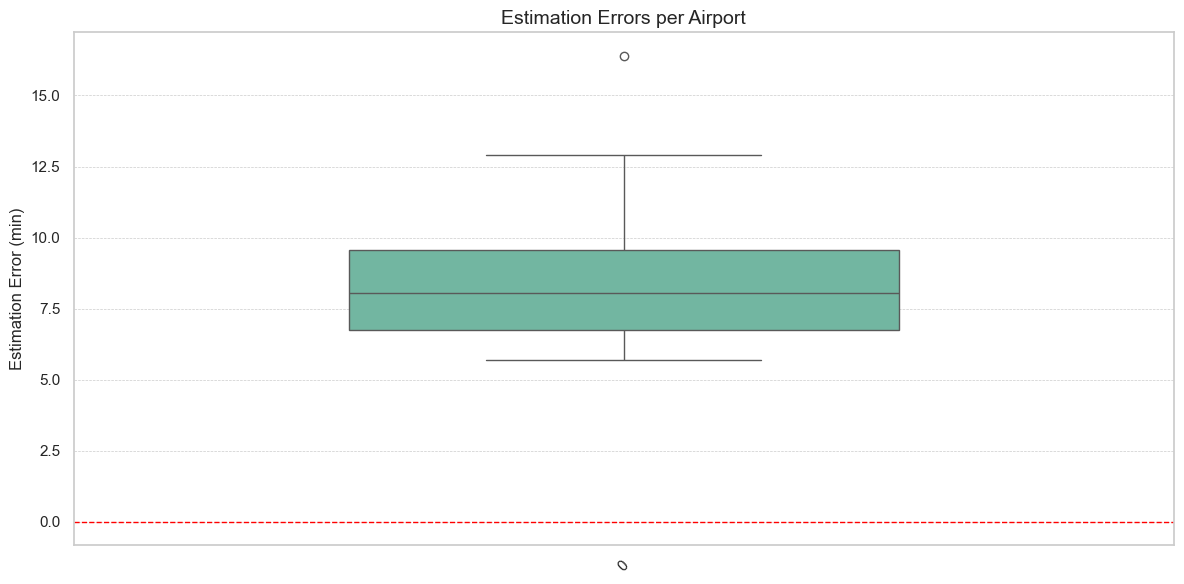

In [ ]:
max_airports = 50
data_grid = data.iloc[:max_airports].reset_index(drop=True)
num_airports = len(data_grid)

# Compute circle sizes (adjust scaling factor as needed)
max_mae = data_grid['MAE'].max()
sizes = data_grid['MAE'] / max_mae * 3000  # Adjust the multiplier to change circle sizes

# Normalize MAE values for color mapping
norm = mcolors.Normalize(vmin=data_grid['MAE'].min(), vmax=data_grid['MAE'].max())
cmap = cm.get_cmap('coolwarm')
colors = [cmap(norm(value)) for value in data_grid['MAE']]

# Grid dimensions
grid_rows = 5
grid_cols = 10

fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols*1.5, grid_rows*1.5))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < num_airports:
        mae_value = data_grid['MAE'].iloc[i]
        color = colors[i]
        ax.scatter(0.5, 0.5, s=sizes.iloc[i], color=color, alpha=0.6)
        ax.text(0.5, 0.5, f"{mae_value:.1f}", ha='center', va='center', fontsize=12)
        ax.axis('off')  # Remove the box around the circle
        ax.set_title(data_grid['Airport'].iloc[i], fontsize=10)
    else:
        ax.axis('off')  # Hide unused subplots

plt.suptitle('MAE per Airport', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Baseline MAE on Test Set: 7.8317
bnames=['distance', 'cap_DES', 'cap_DEP', 'ADEP_capacity', 'ADEPLong', 'ADEPLat', 'ADES_capacity', 'ADEP_EBBR', 'ADEP_EDDF', 'ADEP_EDDH', 'ADEP_EDDK', 'ADEP_EDDL', 'ADEP_EDDM', 'ADEP_EDDS', 'ADEP_EFHK', 'ADEP_EGBB', 'ADEP_EGCC', 'ADEP_EGGW', 'ADEP_EGKK', 'ADEP_EGLL', 'ADEP_EGPH', 'ADEP_EGSS', 'ADEP_EIDW', 'ADEP_EKCH', 'ADEP_ENGM', 'ADEP_EPWA', 'ADEP_ESSA', 'ADEP_LEAL', 'ADEP_LEBL', 'ADEP_LEMD', 'ADEP_LEMG', 'ADEP_LEPA', 'ADEP_LFLL', 'ADEP_LFMN', 'ADEP_LFPG', 'ADEP_LFPO', 'ADEP_LGAV', 'ADEP_LHBP', 'ADEP_LIMC', 'ADEP_LIME', 'ADEP_LIRF', 'ADEP_LKPR', 'ADEP_LOWW', 'ADEP_LPPR', 'ADEP_LPPT', 'ADEP_LROP', 'ADEP_LSGG', 'ADEP_LSZH', 'ADEP_LTBA', 'ADEP_LTFM', 'ADEP_ULLI', 'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'sin_ETOT', 'cos_ETOT', 'sin_ETA', 'cos_ETA', 'TOBTdelay', 'TSATdelay', 'atfmdelay', 'cobt_delay', 'eflighttime', 'etodepdelay', 'fltstate_FI', 'fltstate_SI', 'fltstate_other', 

Features:   0%|          | 0/82 [00:00<?, ?it/s]

feature='distance'


Features:   1%|          | 1/82 [00:05<06:49,  5.06s/it]

feature='cap_DES'


Features:   2%|▏         | 2/82 [00:08<05:30,  4.13s/it]

feature='cap_DEP'


Features:   4%|▎         | 3/82 [00:12<05:03,  3.84s/it]

feature='ADEP_capacity'


Features:   5%|▍         | 4/82 [00:15<04:48,  3.70s/it]

feature='ADEPLong'


Features:   6%|▌         | 5/82 [00:18<04:38,  3.62s/it]

feature='ADEPLat'


Features:   7%|▋         | 6/82 [00:22<04:31,  3.57s/it]

feature='ADES_capacity'


Features:   9%|▊         | 7/82 [00:25<04:25,  3.54s/it]

feature='ADEP_EBBR'


Features:  10%|▉         | 8/82 [00:29<04:20,  3.52s/it]

feature='ADEP_EDDF'


Features:  11%|█         | 9/82 [00:32<04:15,  3.51s/it]

feature='ADEP_EDDH'


Features:  12%|█▏        | 10/82 [00:36<04:11,  3.50s/it]

feature='ADEP_EDDK'


Features:  13%|█▎        | 11/82 [00:39<04:07,  3.49s/it]

feature='ADEP_EDDL'


Features:  15%|█▍        | 12/82 [00:43<04:03,  3.49s/it]

feature='ADEP_EDDM'


Features:  16%|█▌        | 13/82 [00:46<04:00,  3.49s/it]

feature='ADEP_EDDS'


Features:  17%|█▋        | 14/82 [00:50<03:57,  3.49s/it]

feature='ADEP_EFHK'


Features:  18%|█▊        | 15/82 [00:53<03:53,  3.48s/it]

feature='ADEP_EGBB'


Features:  20%|█▉        | 16/82 [00:57<03:49,  3.48s/it]

feature='ADEP_EGCC'


Features:  21%|██        | 17/82 [01:00<03:46,  3.48s/it]

feature='ADEP_EGGW'


Features:  22%|██▏       | 18/82 [01:04<03:42,  3.48s/it]

feature='ADEP_EGKK'


Features:  23%|██▎       | 19/82 [01:07<03:39,  3.48s/it]

feature='ADEP_EGLL'


Features:  24%|██▍       | 20/82 [01:11<03:35,  3.48s/it]

feature='ADEP_EGPH'


Features:  26%|██▌       | 21/82 [01:14<03:32,  3.48s/it]

feature='ADEP_EGSS'


Features:  27%|██▋       | 22/82 [01:18<03:28,  3.48s/it]

feature='ADEP_EIDW'


Features:  28%|██▊       | 23/82 [01:21<03:25,  3.48s/it]

feature='ADEP_EKCH'


Features:  29%|██▉       | 24/82 [01:25<03:21,  3.48s/it]

feature='ADEP_ENGM'


Features:  30%|███       | 25/82 [01:28<03:18,  3.48s/it]

feature='ADEP_EPWA'


Features:  32%|███▏      | 26/82 [01:32<03:14,  3.48s/it]

feature='ADEP_ESSA'


Features:  33%|███▎      | 27/82 [01:35<03:11,  3.48s/it]

feature='ADEP_LEAL'


Features:  34%|███▍      | 28/82 [01:39<03:08,  3.48s/it]

feature='ADEP_LEBL'


Features:  35%|███▌      | 29/82 [01:42<03:04,  3.48s/it]

feature='ADEP_LEMD'


Features:  37%|███▋      | 30/82 [01:45<03:01,  3.48s/it]

feature='ADEP_LEMG'


Features:  38%|███▊      | 31/82 [01:49<02:57,  3.48s/it]

feature='ADEP_LEPA'


Features:  39%|███▉      | 32/82 [01:52<02:53,  3.48s/it]

feature='ADEP_LFLL'


Features:  40%|████      | 33/82 [01:56<02:50,  3.48s/it]

feature='ADEP_LFMN'


Features:  41%|████▏     | 34/82 [01:59<02:47,  3.48s/it]

feature='ADEP_LFPG'


Features:  43%|████▎     | 35/82 [02:03<02:43,  3.48s/it]

feature='ADEP_LFPO'


Features:  44%|████▍     | 36/82 [02:06<02:40,  3.49s/it]

feature='ADEP_LGAV'


Features:  45%|████▌     | 37/82 [02:10<02:36,  3.49s/it]

feature='ADEP_LHBP'


Features:  46%|████▋     | 38/82 [02:13<02:33,  3.48s/it]

feature='ADEP_LIMC'


Features:  48%|████▊     | 39/82 [02:17<02:29,  3.48s/it]

feature='ADEP_LIME'


Features:  49%|████▉     | 40/82 [02:20<02:26,  3.48s/it]

feature='ADEP_LIRF'


Features:  50%|█████     | 41/82 [02:24<02:22,  3.47s/it]

feature='ADEP_LKPR'


Features:  51%|█████     | 42/82 [02:27<02:18,  3.47s/it]

feature='ADEP_LOWW'


Features:  52%|█████▏    | 43/82 [02:31<02:15,  3.47s/it]

feature='ADEP_LPPR'


Features:  54%|█████▎    | 44/82 [02:34<02:11,  3.46s/it]

feature='ADEP_LPPT'


Features:  55%|█████▍    | 45/82 [02:38<02:07,  3.45s/it]

feature='ADEP_LROP'


Features:  56%|█████▌    | 46/82 [02:41<02:04,  3.46s/it]

feature='ADEP_LSGG'


Features:  57%|█████▋    | 47/82 [02:44<02:00,  3.46s/it]

feature='ADEP_LSZH'


Features:  59%|█████▊    | 48/82 [02:48<01:57,  3.45s/it]

feature='ADEP_LTBA'


Features:  60%|█████▉    | 49/82 [02:51<01:53,  3.45s/it]

feature='ADEP_LTFM'


Features:  61%|██████    | 50/82 [02:55<01:50,  3.45s/it]

feature='ADEP_ULLI'


Features:  62%|██████▏   | 51/82 [02:58<01:46,  3.45s/it]

feature='day_of_week_0'


Features:  63%|██████▎   | 52/82 [03:02<01:43,  3.45s/it]

feature='day_of_week_1'


Features:  65%|██████▍   | 53/82 [03:05<01:40,  3.45s/it]

feature='day_of_week_2'


Features:  66%|██████▌   | 54/82 [03:09<01:36,  3.45s/it]

feature='day_of_week_3'


Features:  67%|██████▋   | 55/82 [03:12<01:33,  3.45s/it]

feature='day_of_week_4'


Features:  68%|██████▊   | 56/82 [03:16<01:29,  3.45s/it]

feature='day_of_week_5'


Features:  70%|██████▉   | 57/82 [03:19<01:26,  3.45s/it]

feature='day_of_week_6'


Features:  71%|███████   | 58/82 [03:22<01:22,  3.45s/it]

feature='sin_ETOT'


Features:  72%|███████▏  | 59/82 [03:26<01:19,  3.45s/it]

feature='cos_ETOT'


Features:  73%|███████▎  | 60/82 [03:29<01:15,  3.45s/it]

feature='sin_ETA'


Features:  74%|███████▍  | 61/82 [03:33<01:12,  3.45s/it]

feature='cos_ETA'


Features:  76%|███████▌  | 62/82 [03:36<01:09,  3.45s/it]

feature='TOBTdelay'


Features:  77%|███████▋  | 63/82 [03:40<01:05,  3.45s/it]

feature='TSATdelay'


Features:  78%|███████▊  | 64/82 [03:43<01:02,  3.45s/it]

feature='atfmdelay'


Features:  79%|███████▉  | 65/82 [03:47<00:58,  3.44s/it]

feature='cobt_delay'


Features:  80%|████████  | 66/82 [03:50<00:55,  3.45s/it]

feature='eflighttime'


Features:  82%|████████▏ | 67/82 [03:53<00:51,  3.45s/it]

feature='etodepdelay'


Features:  83%|████████▎ | 68/82 [03:57<00:48,  3.45s/it]

feature='fltstate_FI'


Features:  84%|████████▍ | 69/82 [04:00<00:44,  3.45s/it]

feature='fltstate_SI'


Features:  85%|████████▌ | 70/82 [04:04<00:41,  3.45s/it]

feature='fltstate_other'


Features:  87%|████████▋ | 71/82 [04:07<00:37,  3.45s/it]

feature='ko'


Features:  88%|████████▊ | 72/82 [04:11<00:34,  3.46s/it]

feature='modeltyp_ACT'


Features:  89%|████████▉ | 73/82 [04:14<00:31,  3.46s/it]

feature='modeltyp_CAL'


Features:  90%|█████████ | 74/82 [04:18<00:27,  3.47s/it]

feature='modeltyp_EST'


Features:  91%|█████████▏| 75/82 [04:21<00:24,  3.46s/it]

feature='offblock'


Features:  93%|█████████▎| 76/82 [04:25<00:20,  3.47s/it]

feature='regulations'


Features:  94%|█████████▍| 77/82 [04:28<00:17,  3.47s/it]

feature='timetoCBAS'


Features:  95%|█████████▌| 78/82 [04:32<00:13,  3.46s/it]

feature='visibility'


Features:  96%|█████████▋| 79/82 [04:35<00:10,  3.47s/it]

feature='wdirec'


Features:  98%|█████████▊| 80/82 [04:38<00:06,  3.46s/it]

feature='wguts'


Features:  99%|█████████▉| 81/82 [04:42<00:03,  3.46s/it]

feature='wspeed'


Features: 100%|██████████| 82/82 [04:45<00:00,  3.49s/it]


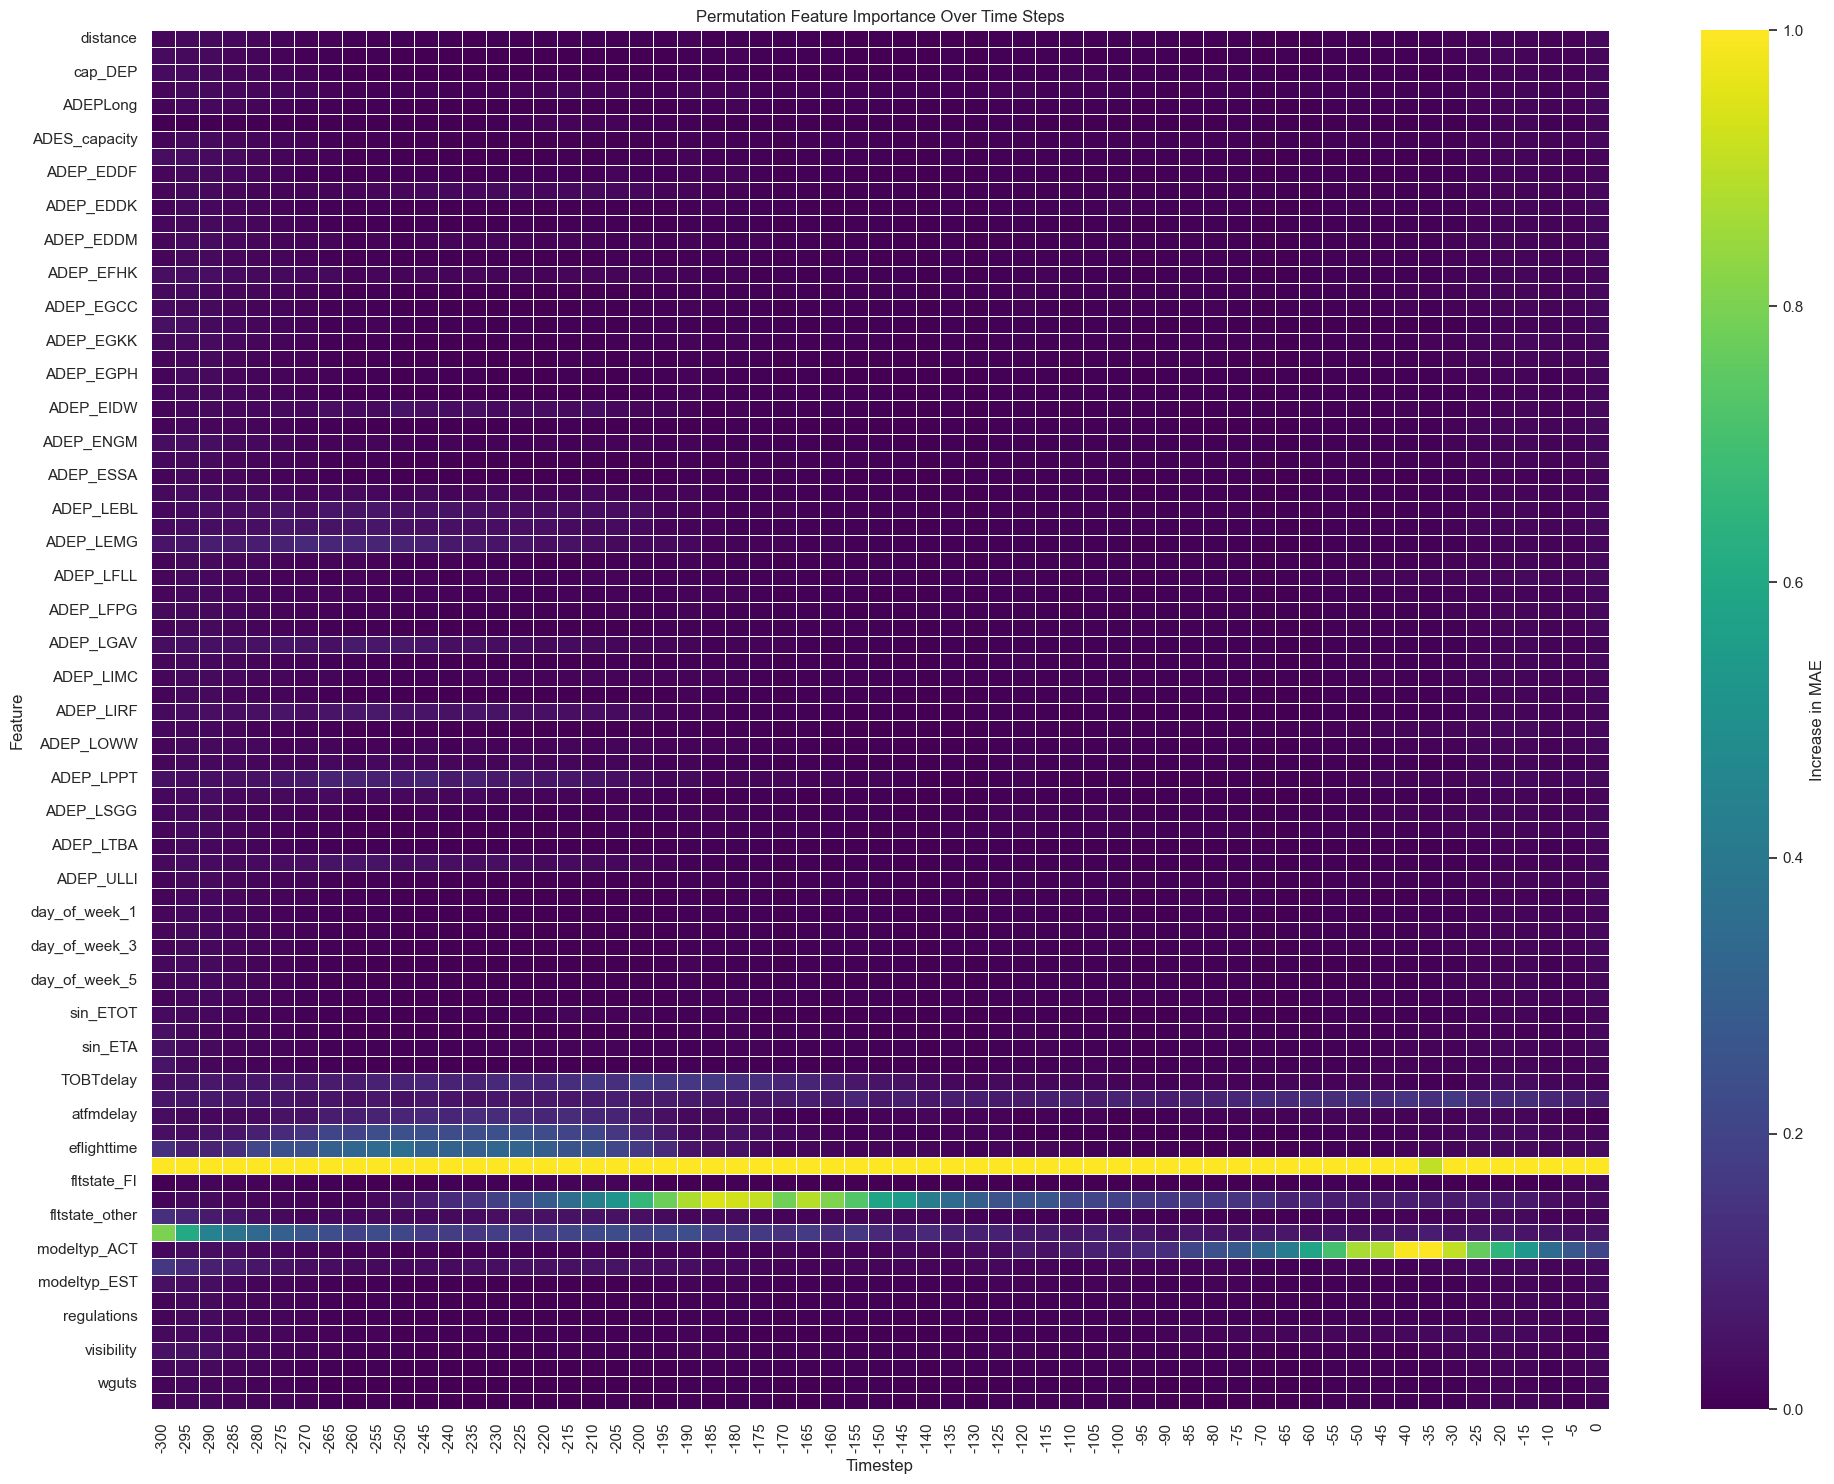

In [136]:

bnames =data_prep.basenames
# Plot feature importance
input_size = data_prep.input_size

model_trainer = LSTMModelTrainerAttention(data_prep=data_prep, input_size=input_size, model_type='varattention')

baseline = model_trainer.compute_baseline_mae(best_model, X_test_tensor[:10000], y_test_tensor[:10000], data_prep.scaler_y, time_horizons)
imp_df = model_trainer.compute_permutation_importance(best_model, X_test_tensor[:10000], y_test_tensor[:10000], data_prep.scaler_y, time_horizons, bnames)

from sklearn.preprocessing import MinMaxScaler
def normalize_dataframe_minmax(df, feature_range=(0, 1)):
    """
    Normalize the entire DataFrame using MinMaxScaler.
    
    :param df: pandas DataFrame to normalize
    :param feature_range: tuple (min, max) desired range of transformed data
    :return: Normalized DataFrame, fitted scaler
    """
    scaler = MinMaxScaler(feature_range=feature_range)
    scaled_array = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_array, columns=df.columns, index=df.index)
    return scaled_df, scaler

impdf2, scaler = normalize_dataframe_minmax(imp_df)
model_trainer.plot_permutation_importance(impdf2)
model_trainer.plot_permutation_importance_with_highlights_interactive(imp_df, ['ko', 'visibility','etodepdelay', 'TOBTdelay', 'TSATdelay'])

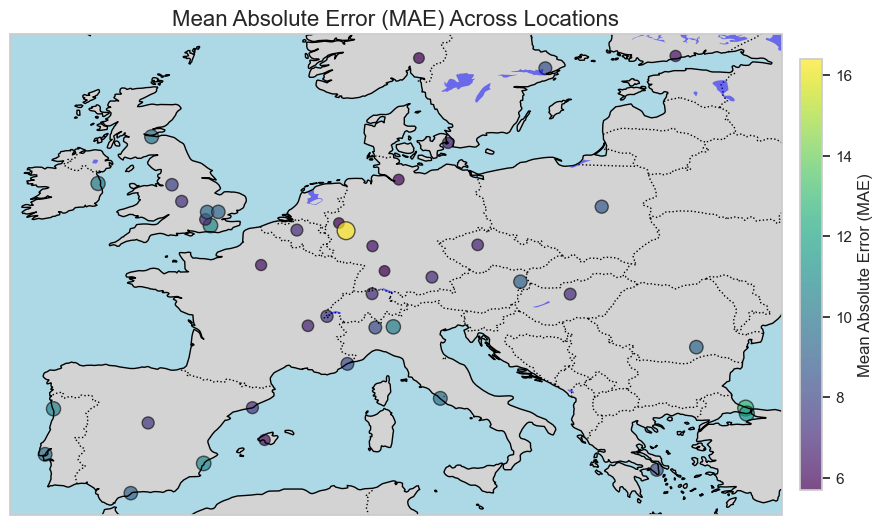

In [130]:
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# Assuming adeplatlonlist is already populated as defaultdict(list)
# Each key is a tuple (latitude, longitude)
# Each value is a list of numpy arrays containing MAE per timestep

mean_error_per_location = {}

for (lat, lon), errors_list in adeplatlonlist.items():
    # Concatenate all error arrays for the current location
    all_errors = np.concatenate(errors_list)
    
    # Compute the mean MAE, ignoring NaN values
    mean_mae = np.nanmean(all_errors)
    
    mean_error_per_location[(lat, lon)] = mean_mae

# Convert the dictionary to a pandas DataFrame for easier handling
data = pd.DataFrame([
    {'Latitude': lat, 'Longitude': lon, 'Mean_MAE': mae}
    for (lat, lon), mae in mean_error_per_location.items()
])
# Create a figure and a GeoAxes
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add coastlines and other features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, facecolor='lightgrey')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.LAKES, facecolor='blue', alpha=0.5)

# Scatter plot of data points
sc = plt.scatter(
    data['Longitude'],
    data['Latitude'],
    c=data['Mean_MAE'],
    s=data['Mean_MAE'] * 10,  # Scale marker size
    cmap='viridis',
    alpha=0.7,
    edgecolors='k',
    transform=ccrs.PlateCarree()
)

# Add a colorbar
cbar = plt.colorbar(sc, orientation='vertical', pad=0.02, shrink=0.7)
cbar.set_label('Mean Absolute Error (MAE)')

# Add title and labels
plt.title('Mean Absolute Error (MAE) Across Locations', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Show the plot
plt.show()